### 1. Importacion de Librerias y Carga de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("husl")

# Cargar datos
ruta = 'application_train.csv'
datos = pd.read_csv(ruta)

print(f"Datos: {datos.shape} | Fraude: {datos['TARGET'].mean()*100:.1f}%")
datos.head()

Datos: (307511, 122) | Fraude: 8.1%


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Preparacion de Datos (SOLO NUMERICAS)

In [2]:
# Seleccionar SOLO columnas numericas
columnas_numericas = [
    'TARGET',
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'CNT_FAM_MEMBERS',
    'HOUR_APPR_PROCESS_START',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'OWN_CAR_AGE',
    'REGION_POPULATION_RELATIVE',
    'DAYS_LAST_PHONE_CHANGE'
]

# Filtrar solo las que existen
columnas_usar = [col for col in columnas_numericas if col in datos.columns]
datos_completos = datos[columnas_usar].copy()

print(f"Columnas numericas seleccionadas: {len(columnas_usar)}")
print(f"Columnas: {columnas_usar}")

# Rellenar valores nulos con la mediana
for col in datos_completos.columns:
    if datos_completos[col].isnull().any():
        datos_completos[col].fillna(datos_completos[col].median(), inplace=True)

# Renombrar a español
nombres_espanol = {
    'TARGET': 'objetivo',
    'CNT_CHILDREN': 'num_hijos',
    'AMT_INCOME_TOTAL': 'ingreso_total',
    'AMT_CREDIT': 'monto_credito',
    'AMT_ANNUITY': 'anualidad',
    'AMT_GOODS_PRICE': 'precio_bienes',
    'DAYS_BIRTH': 'edad_dias',
    'DAYS_EMPLOYED': 'dias_empleado',
    'DAYS_REGISTRATION': 'dias_registro',
    'DAYS_ID_PUBLISH': 'dias_id_publicado',
    'CNT_FAM_MEMBERS': 'miembros_familia',
    'HOUR_APPR_PROCESS_START': 'hora_inicio_proceso',
    'EXT_SOURCE_1': 'score_externo_1',
    'EXT_SOURCE_2': 'score_externo_2',
    'EXT_SOURCE_3': 'score_externo_3',
    'OWN_CAR_AGE': 'antiguedad_auto',
    'REGION_POPULATION_RELATIVE': 'poblacion_region',
    'DAYS_LAST_PHONE_CHANGE': 'dias_cambio_telefono'
}

datos_completos.rename(columns=nombres_espanol, inplace=True)

print(f"\nDatos preparados: {datos_completos.shape}")
print(f"Valores nulos: {datos_completos.isnull().sum().sum()}")
print(f"\nTodas las columnas son numericas (int/float)")

Columnas numericas seleccionadas: 18
Columnas: ['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE']

Datos preparados: (307511, 18)
Valores nulos: 0

Todas las columnas son numericas (int/float)

Datos preparados: (307511, 18)
Valores nulos: 0

Todas las columnas son numericas (int/float)


### 3. Division de Datos para Semi-Supervisado

Simulamos un escenario realista:
- Eliminamos el 70% de las etiquetas del conjunto de entrenamiento
- Solo 30% de datos tienen etiquetas disponibles
- El algoritmo semi-supervisado usara el 70% restante para mejorar

In [3]:
# Separar features y target
X = datos_completos.drop(['objetivo'], axis=1)
y = datos_completos['objetivo']

print(f"Features numericas usadas: {X.shape[1]}")
print(f"Lista de features: {list(X.columns)}")

# Division 1: train 80%, test 20%
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Division 2: simular datos sin etiquetas (70% del train)
X_etiquetado, X_sin_etiquetar, y_etiquetado, y_sin_etiquetar_real = train_test_split(
    X_train_full, y_train_full, test_size=0.70, random_state=42, stratify=y_train_full
)

# Normalizar
scaler = StandardScaler()
X_etiquetado_scaled = scaler.fit_transform(X_etiquetado)
X_sin_etiquetar_scaled = scaler.transform(X_sin_etiquetar)
X_test_scaled = scaler.transform(X_test)

print(f"\nESCENARIO SEMI-SUPERVISADO:")
print("="*60)
print(f"Datos etiquetados:     {len(X_etiquetado):,} (30%)")
print(f"Datos sin etiquetas:   {len(X_sin_etiquetar):,} (70%)")
print(f"Datos de test:         {len(X_test):,}")
print(f"\nTotal features numericas: {X.shape[1]}")

Features numericas usadas: 17
Lista de features: ['num_hijos', 'ingreso_total', 'monto_credito', 'anualidad', 'precio_bienes', 'edad_dias', 'dias_empleado', 'dias_registro', 'dias_id_publicado', 'miembros_familia', 'hora_inicio_proceso', 'score_externo_1', 'score_externo_2', 'score_externo_3', 'antiguedad_auto', 'poblacion_region', 'dias_cambio_telefono']

ESCENARIO SEMI-SUPERVISADO:
Datos etiquetados:     73,802 (30%)
Datos sin etiquetas:   172,206 (70%)
Datos de test:         61,503

Total features numericas: 17

ESCENARIO SEMI-SUPERVISADO:
Datos etiquetados:     73,802 (30%)
Datos sin etiquetas:   172,206 (70%)
Datos de test:         61,503

Total features numericas: 17


### 4. Modelo Base (Solo Datos Etiquetados)

In [4]:
print("Entrenando Modelo Base (solo 30% etiquetados)...\n")

modelo_base = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

modelo_base.fit(X_etiquetado_scaled, y_etiquetado)
y_pred_base = modelo_base.predict(X_test_scaled)

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, zero_division=0)
rec_base = recall_score(y_test, y_pred_base, zero_division=0)
f1_base = f1_score(y_test, y_pred_base, zero_division=0)

print("MODELO BASE (solo 30% etiquetados):")
print("="*50)
print(f"Accuracy:  {acc_base:.6f}")
print(f"Precision: {prec_base:.6f}")
print(f"Recall:    {rec_base:.6f}")
print(f"F1-Score:  {f1_base:.6f}")

Entrenando Modelo Base (solo 30% etiquetados)...

MODELO BASE (solo 30% etiquetados):
Accuracy:  0.836919
Precision: 0.217513
Recall:    0.392749
F1-Score:  0.279971
MODELO BASE (solo 30% etiquetados):
Accuracy:  0.836919
Precision: 0.217513
Recall:    0.392749
F1-Score:  0.279971


### 5. Modelo Semi-Supervisado (Self-Training)

In [ ]:
print("Entrenando Modelo Semi-Supervisado (Self-Training)...\n")

# Copias de trabajo
X_train_temp = X_etiquetado_scaled.copy()
y_train_temp = y_etiquetado.copy()
X_unlabeled_temp = X_sin_etiquetar_scaled.copy()

# Configuracion
umbral_confianza = 0.95
max_iteraciones = 10
ejemplos_por_iteracion = 5000

print("Configuracion:")
print(f"  Umbral de confianza: {umbral_confianza}")
print(f"  Max iteraciones: {max_iteraciones}")
print(f"  Ejemplos por iteracion: {ejemplos_por_iteracion}")
print()

# Entrenar modelo inicial
modelo_semisup = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

modelo_semisup.fit(X_train_temp, y_train_temp)

# Self-training iterativo
for iteracion in range(max_iteraciones):
    
    if len(X_unlabeled_temp) == 0:
        print("No quedan datos sin etiquetar")
        break
    
    # Predecir con probabilidades
    probs = modelo_semisup.predict_proba(X_unlabeled_temp)
    confianza = np.max(probs, axis=1)
    predicciones = np.argmax(probs, axis=1)
    
    # Seleccionar predicciones confiables
    indices_confiables = np.where(confianza >= umbral_confianza)[0]
    
    if len(indices_confiables) == 0:
        print(f"Iteracion {iteracion+1}: Sin predicciones confiables")
        break
    
    # Limitar cantidad por iteracion
    if len(indices_confiables) > ejemplos_por_iteracion:
        indices_ordenados = np.argsort(confianza)[::-1]
        indices_confiables = indices_ordenados[:ejemplos_por_iteracion]
    
    # Contar por clase
    nuevas_etiquetas = predicciones[indices_confiables]
    n_clase_0 = np.sum(nuevas_etiquetas == 0)
    n_clase_1 = np.sum(nuevas_etiquetas == 1)
    
    print(f"Iteracion {iteracion+1}: Agregados {len(indices_confiables)} ejemplos (Clase 0: {n_clase_0}, Clase 1: {n_clase_1})")
    
    # Agregar datos confiables
    X_train_temp = np.vstack([X_train_temp, X_unlabeled_temp[indices_confiables]])
    y_train_temp = np.hstack([y_train_temp, nuevas_etiquetas])
    
    # Remover datos agregados
    X_unlabeled_temp = np.delete(X_unlabeled_temp, indices_confiables, axis=0)
    
    # Re-entrenar
    modelo_semisup.fit(X_train_temp, y_train_temp)

print(f"\nDatos finales de entrenamiento: {len(X_train_temp):,}")
print(f"Datos sin etiquetar restantes: {len(X_unlabeled_temp):,}")

# Evaluar
y_pred_semisup = modelo_semisup.predict(X_test_scaled)

acc_semisup = accuracy_score(y_test, y_pred_semisup)
prec_semisup = precision_score(y_test, y_pred_semisup, zero_division=0)
rec_semisup = recall_score(y_test, y_pred_semisup, zero_division=0)
f1_semisup = f1_score(y_test, y_pred_semisup, zero_division=0)

print("\nMODELO SEMI-SUPERVISADO:")
print("="*50)
print(f"Accuracy:  {acc_semisup:.6f}")
print(f"Precision: {prec_semisup:.6f}")
print(f"Recall:    {rec_semisup:.6f}")
print(f"F1-Score:  {f1_semisup:.6f}")

Entrenando Modelo Semi-Supervisado (Self-Training)...

Configuracion:
  Umbral de confianza: 0.95
  Max iteraciones: 10
  Ejemplos por iteracion: 5000

Iteracion 1: Agregados 2163 ejemplos (Clase 0: 2163, Clase 1: 0)
Iteracion 1: Agregados 2163 ejemplos (Clase 0: 2163, Clase 1: 0)
Iteracion 2: Agregados 2361 ejemplos (Clase 0: 2361, Clase 1: 0)
Iteracion 2: Agregados 2361 ejemplos (Clase 0: 2361, Clase 1: 0)


### 6. Comparacion de Resultados

In [ ]:
resultados = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Base': [acc_base, prec_base, rec_base, f1_base],
    'Semi-Supervisado': [acc_semisup, prec_semisup, rec_semisup, f1_semisup]
})

resultados['Mejora'] = (
    (resultados['Semi-Supervisado'] - resultados['Modelo Base']) / 
    resultados['Modelo Base'] * 100
)

print("\nCOMPARACION DE MODELOS:")
print("="*80)
print(resultados.to_string(index=False))
print("\n" + "="*80)

mejora_f1 = resultados[resultados['Metrica']=='F1-Score']['Mejora'].values[0]
mejora_recall = resultados[resultados['Metrica']=='Recall']['Mejora'].values[0]

print("\nRESUMEN:")
if mejora_f1 > 0:
    print(f"El modelo semi-supervisado MEJORO el F1-Score en {mejora_f1:.2f}%")
else:
    print(f"El modelo semi-supervisado BAJO el F1-Score en {abs(mejora_f1):.2f}%")
    
if mejora_recall > 0:
    print(f"El Recall MEJORO en {mejora_recall:.2f}%")
else:
    print(f"El Recall BAJO en {abs(mejora_recall):.2f}%")


COMPARACION DE MODELOS:
  Metrica  Modelo Base  Semi-Supervisado    Mejora
 Accuracy     0.836919          0.802579 -4.103122
Precision     0.217513          0.196943 -9.456798
   Recall     0.392749          0.469688 19.589744
 F1-Score     0.279971          0.277520 -0.875573


RESUMEN:
El modelo semi-supervisado BAJO el F1-Score en 0.88%
El Recall MEJORO en 19.59%


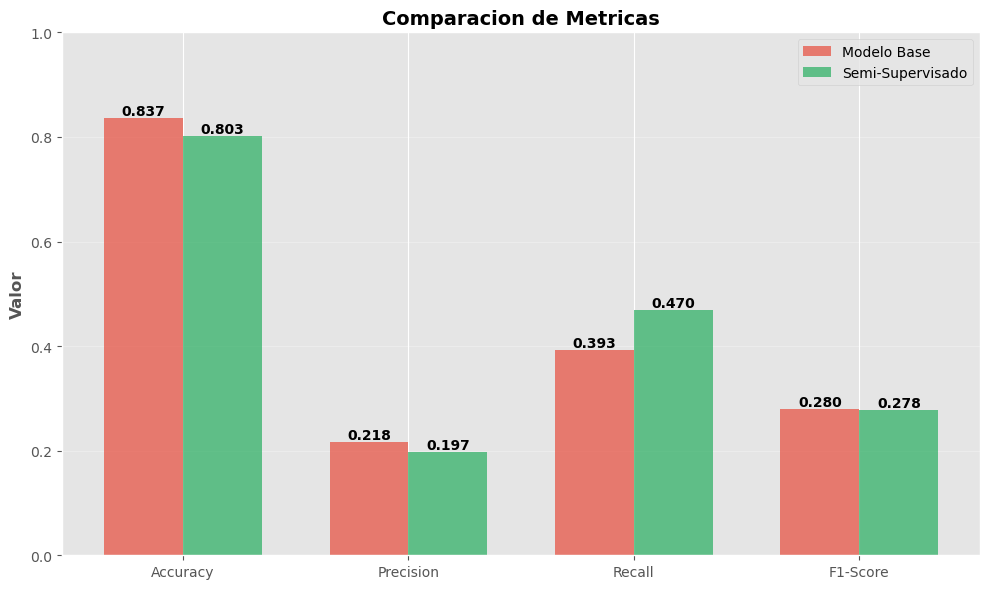

In [ ]:
# Grafico 1: Comparacion de metricas
fig, ax = plt.subplots(figsize=(10, 6))

metricas = resultados['Metrica']
base = resultados['Modelo Base']
semisup = resultados['Semi-Supervisado']

x = np.arange(len(metricas))
ancho = 0.35

barras1 = ax.bar(x - ancho/2, base, ancho, label='Modelo Base', color='#3498db', alpha=0.8)
barras2 = ax.bar(x + ancho/2, semisup, ancho, label='Semi-Supervisado', color='#2ecc71', alpha=0.8)

ax.set_ylabel('Valor', fontweight='bold')
ax.set_title('Comparacion de Metricas', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bar in barras1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
            
for bar in barras2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

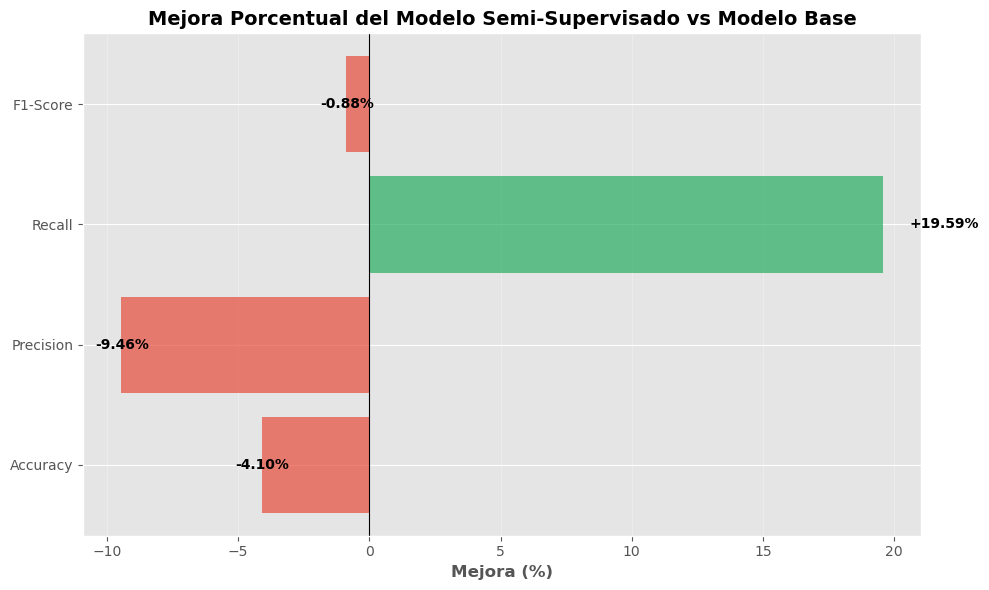

In [ ]:
# Grafico 2: Mejora porcentual
fig, ax = plt.subplots(figsize=(10, 6))

mejoras = resultados['Mejora']
colores = ['#2ecc71' if m > 0 else '#3498db' for m in mejoras]

barras = ax.barh(metricas, mejoras, color=colores, alpha=0.7)

ax.set_xlabel('Mejora (%)', fontweight='bold')
ax.set_title('Mejora Porcentual del Modelo Semi-Supervisado vs Modelo Base', fontweight='bold', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

for i, (bar, valor) in enumerate(zip(barras, mejoras)):
    ax.text(valor + 1 if valor > 0 else valor - 1, i, 
            f'{valor:+.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

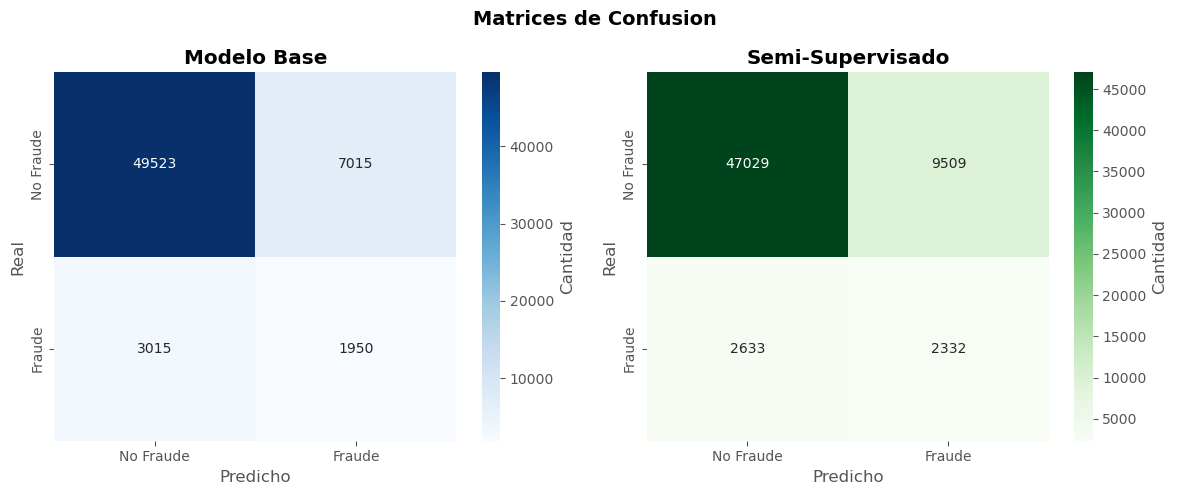

In [ ]:
# Grafico 3: Matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Cantidad'})
axes[0].set_title('Modelo Base', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')
axes[0].set_xticklabels(['No Fraude', 'Fraude'])
axes[0].set_yticklabels(['No Fraude', 'Fraude'])

cm_semisup = confusion_matrix(y_test, y_pred_semisup)
sns.heatmap(cm_semisup, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar_kws={'label': 'Cantidad'})
axes[1].set_title('Semi-Supervisado', fontweight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predicho')
axes[1].set_xticklabels(['No Fraude', 'Fraude'])
axes[1].set_yticklabels(['No Fraude', 'Fraude'])

plt.suptitle('Matrices de Confusion', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Grafico 4: Tabla de deteccion
tabla_fraudes = pd.DataFrame({
    'Categoria': [
        'Fraudes detectados correctamente',
        'Fraudes NO detectados (error)',
        'Falsas alarmas (error)',
        'No fraude correcto'
    ],
    'Modelo Base': [cm_base[1,1], cm_base[1,0], cm_base[0,1], cm_base[0,0]],
    'Semi-Supervisado': [cm_semisup[1,1], cm_semisup[1,0], cm_semisup[0,1], cm_semisup[0,0]]
})

print("\nANALISIS DE DETECCION DE FRAUDES")
print("="*80)
print(tabla_fraudes.to_string(index=False))
print(f"\nTotal de fraudes reales en prueba: {cm_base[1,0] + cm_base[1,1]}")
print(f"Tasa de deteccion Modelo Base: {cm_base[1,1]/(cm_base[1,0] + cm_base[1,1])*100:.1f}%")
print(f"Tasa de deteccion Semi-Supervisado: {cm_semisup[1,1]/(cm_semisup[1,0] + cm_semisup[1,1])*100:.1f}%")


ANALISIS DE DETECCION DE FRAUDES
                       Categoria  Modelo Base  Semi-Supervisado
Fraudes detectados correctamente         1950              2332
   Fraudes NO detectados (error)         3015              2633
          Falsas alarmas (error)         7015              9509
              No fraude correcto        49523             47029

Total de fraudes reales en prueba: 4965
Tasa de deteccion Modelo Base: 39.3%
Tasa de deteccion Semi-Supervisado: 47.0%
